In [1]:
import numpy as np
import matplotlib.pyplot as plt
import stim
from lib.stabilizer import measurement_gadgets, StabilizerCode, stabilizer_circuits
from lib.color_compass import *
from lib.decoder import checkmatrix,pL_from_checkmatrix
from lib.stim2pymatching import estimate_pL_noisy_graph
import stimcirq
from typing import *
from cirq.contrib.svg import SVGCircuit
import networkx as nx
import time
from tqdm import tqdm
import scipy.stats as ss
import pickle
from pymatching import Matching
from ldpc import bposd_decoder
from CompassCode import Lattice2D, choose_gauge_fixing, random_pauli, print_pauli_error, random_pauli_asym, pcheck_clipX, pcheck_clipZ

%load_ext autoreload
%autoreload 2

## Depolarizing Noise

In [45]:
dim = 10
lat = Lattice2D(dim, dim)
coloring = 1 * np.ones((dim - 1)**2)
litmus_lat = compass_to_surface(dim ,dim)
lat.color_lattice(coloring)
rate = 0.02
num_errors = 1000
rates = [rate, rate, rate]
synd_sens_abs_diff = []
for err in range(num_errors):
    E = random_pauli(lat.size(), rates)
    while E == 'I' * lat.size():
        E = random_pauli(lat.size(), rates)
    error = pauli2vector(E)
    pcheckX = litmus_lat.pcheckX() 
    pcheckZ = litmus_lat.pcheckZ() 
    pcheck = np.vstack((pcheckX, pcheckZ)) 
    syndromeZ = twisted_product(pcheckX, pauli2vector(E)) # Z-error syndrome 
    syndromeX = twisted_product(pcheckZ, pauli2vector(E)) # X-error syndrome 
    synd_sens_abs_diff.append(np.sum(syndromeZ) - np.sum(syndromeX))

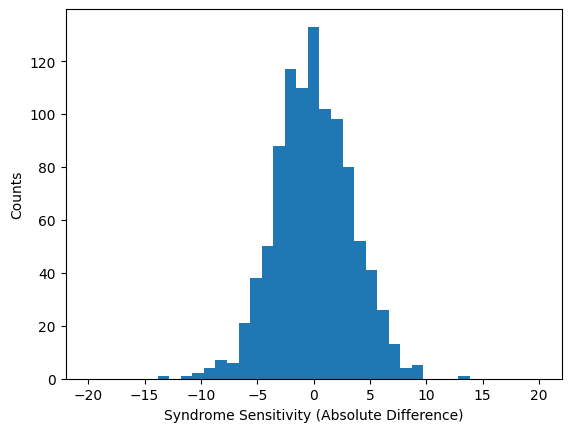

In [46]:
fig, ax = plt.subplots()
bins = np.linspace(-20,20,40)
ax.hist(synd_sens_abs_diff, bins)
ax.set_xlabel('Syndrome Sensitivity (Absolute Difference)')
ax.set_ylabel('Counts')
plt.show()

## Biased Depolarizing Noise

In [ ]:
# Compass Code Simulation
dims = [3,5,7,9,11,15]
phys_err_rates_range = np.linspace(0.0001, 0.1, 10)
num_errors = 100 
num_gauge_fixings = 10
logical_errors = {dim: np.zeros((num_gauge_fixings, len(phys_err_rates_range),)) for dim in dims}

for dim in tqdm(dims):
    for gf in range(num_gauge_fixings):
        lat = Lattice2D(dim, dim)
        coloring = np.random.randint(-1, 2, size=(dim - 1)**2)
        lat.color_lattice(coloring)
        for i, phys_rate in enumerate(phys_err_rates_range):
            rates = [phys_rate, phys_rate, phys_rate]
            for err in range(num_errors):
                E = random_pauli(lat.size(), rates)
                while E == 'I' * lat.size():
                    E = random_pauli(lat.size(), rates)
                error = pauli2vector(E)
                pcheckX = lat.pcheckX() 
                pcheckZ = lat.pcheckZ() 
                pcheck = np.vstack((pcheckX, pcheckZ)) 
                syndromeZ = twisted_product(pcheckX, pauli2vector(E)) # Z-error syndrome 
                syndromeX = twisted_product(pcheckZ, pauli2vector(E)) # X-error syndrome 
                Hx = pcheck_clipX(pcheckX)
                Hz = pcheck_clipZ(pcheckZ)
                decodingX = Matching.from_check_matrix(Hx)
                decodingZ = Matching.from_check_matrix(Hz)
                recoveryX = decodingX.decode(syndromeZ)
                recoveryZ = decodingZ.decode(syndromeX)
                recovery = np.concatenate((recoveryZ, recoveryX))
                corrected_error = pauli2vector(E) + recovery % 2 

                if (twisted_product(pauli2vector(lat.Lx), corrected_error) == 1) or (twisted_product(pauli2vector(lat.Lz), corrected_error) == 1):
                    logical_errors[dim][gf][i] += 1